<a href="https://colab.research.google.com/github/swapnil-shines/POS_Attachment/blob/main/BanglaBERTT5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

In [ ]:
file_path = '/content/final_pos.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Parse the sentences and their corresponding POS tags
sentences = []
pos_tags = []
for i in range(0, len(lines), 2):  # Every odd line is POS tags, every even line is sentence
    sentence = lines[i].strip()
    pos_tag = lines[i+1].strip()

    # Tokenizing the sentence and POS tag
    word_list = sentence.split()  # List of words in sentence
    pos_list = pos_tag.split()  # List of POS tags corresponding to words

    # Ensure both lists have the same length
    assert len(word_list) == len(pos_list)

    sentences.append(' '.join(word_list))
    pos_tags.append(' '.join(pos_list))

# Convert the data into a DataFrame
df = pd.DataFrame({'Sentence': sentences, 'POS': pos_tags})

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split 30% temp into 15% each

# Print dataset sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 595
Validation set size: 128
Test set size: 128


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2447 (\N{BENGALI LETTER E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


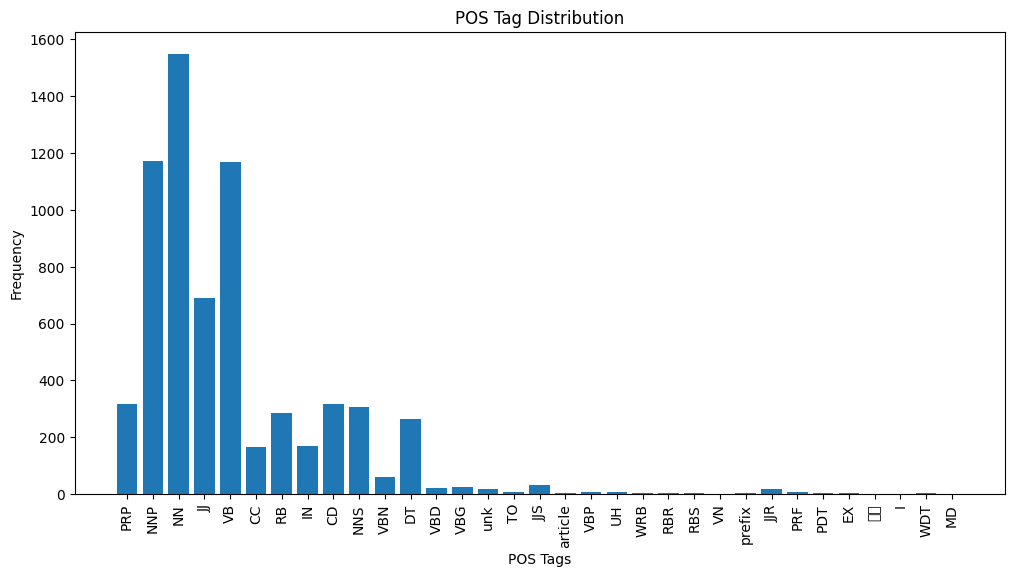

In [ ]:
all_pos_tags = ' '.join(pos_tags).split()  # Flatten all POS tags into a single list
pos_counts = Counter(all_pos_tags)

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.xticks(rotation=90)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('POS Tag Distribution')
plt.show()

In [ ]:
class POSDataset(Dataset):
    def __init__(self, sentences, pos_tags, tokenizer, label_map, max_len=128):
        self.sentences = sentences
        self.pos_tags = pos_tags
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        pos_tags = self.pos_tags[index].split()

        # Tokenize with word alignment
        encoding = self.tokenizer(
            sentence.split(),
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_offsets_mapping=True,
        )

        word_ids = encoding.word_ids()
        labels = [-100 if word_id is None else self.label_map.get(pos_tags[word_id], 0) for word_id in word_ids]

        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }


# Create a label map
label_map = {tag: i for i, tag in enumerate(pos_counts.keys())}

from transformers import AutoModelForTokenClassification

num_labels = len(label_map)
model = AutoModelForTokenClassification.from_pretrained("csebuetnlp/banglabert", num_labels=num_labels)


# Load tokenizer and model
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Prepare datasets
train_dataset = POSDataset(train_df["Sentence"].tolist(), train_df["POS"].tolist(), tokenizer, label_map)
valid_dataset = POSDataset(valid_df["Sentence"].tolist(), valid_df["POS"].tolist(), tokenizer, label_map)
test_dataset = POSDataset(test_df["Sentence"].tolist(), test_df["POS"].tolist(), tokenizer, label_map)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class POSDataset(Dataset):
    def __init__(self, sentences, pos_tags, tokenizer, label_map, max_len=128):
        self.sentences = sentences
        self.pos_tags = pos_tags
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        pos_tags = self.pos_tags[index].split()

        # Tokenize with word alignment
        encoding = self.tokenizer(
            sentence.split(),
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_offsets_mapping=True,
        )

        word_ids = encoding.word_ids()
        labels = [-100 if word_id is None else self.label_map.get(pos_tags[word_id], 0) for word_id in word_ids]

        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }


# Create a label map
label_map = {tag: i for i, tag in enumerate(pos_counts.keys())}

from transformers import AutoModelForTokenClassification

num_labels = len(label_map)
model = AutoModelForTokenClassification.from_pretrained("csebuetnlp/banglat5_nmt_bn_en", num_labels=num_labels)


# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglat5_nmt_bn_en")
model_name = AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/banglat5_nmt_bn_en")

# Prepare datasets
train_dataset = POSDataset(train_df["Sentence"].tolist(), train_df["POS"].tolist(), tokenizer, label_map)
valid_dataset = POSDataset(valid_df["Sentence"].tolist(), valid_df["POS"].tolist(), tokenizer, label_map)
test_dataset = POSDataset(test_df["Sentence"].tolist(), test_df["POS"].tolist(), tokenizer, label_map)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--csebuetnlp--banglat5_nmt_bn_en/snapshots/997417a326d498848f501f5b9a7c6995684b2402/config.json
Model config T5Config {
  "_name_or_path": "csebuetnlp/banglat5_nmt_bn_en",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LA

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Flatten predictions and labels for comparison
    true_labels = labels.flatten()
    pred_labels = predictions.flatten()

    # Filter out padding tokens (label 0)
    valid_indices = true_labels > 0
    true_labels = true_labels[valid_indices]
    pred_labels = pred_labels[valid_indices]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
    accuracy = accuracy_score(true_labels, pred_labels)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,  # Log every 10 steps
    log_level="info",  # Set logging level to info
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=12,
    weight_decay=0.01,
    learning_rate=5e-5,  # Reduced learning rate
    warmup_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[]  # Disable reporting to W&B
)




# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
<ipython-input-14-6957acf26c13>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
***** Running training *****
  Num examples = 595
  Num Epochs = 12
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 456
  Number of trainable parameters = 109,653,921


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,5.466600,5.391462,0.025556,0.173527,0.025556,0.037096
2,5.382400,5.196052,0.034625,0.211197,0.034625,0.051615
3,5.110500,4.879863,0.044518,0.190890,0.044518,0.063888
4,4.604000,4.449534,0.077494,0.232645,0.077494,0.107869
5,4.002900,3.933296,0.124485,0.268616,0.124485,0.161113
6,3.602500,3.338409,0.204452,0.316524,0.204452,0.238066
7,3.002200,2.714270,0.303380,0.367240,0.303380,0.325329
8,2.330800,2.156118,0.432811,0.443510,0.432811,0.430286
9,1.826800,1.727707,0.528442,0.516167,0.528442,0.514651
10,1.405400,1.434784,0.591921,0.570898,0.591921,0.575807



***** Running Evaluation *****
  Num examples = 128
  Batch size = 16
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to ./results/checkpoint-38
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 128, 'num_beams': 4, 'length_penalty': 0.6}
  warnings.warn(
Configurati

TrainOutput(global_step=456, training_loss=3.3781984270664682, metrics={'train_runtime': 398.9948, 'train_samples_per_second': 17.895, 'train_steps_per_second': 1.143, 'total_flos': 465985323740160.0, 'train_loss': 3.3781984270664682, 'epoch': 12.0})

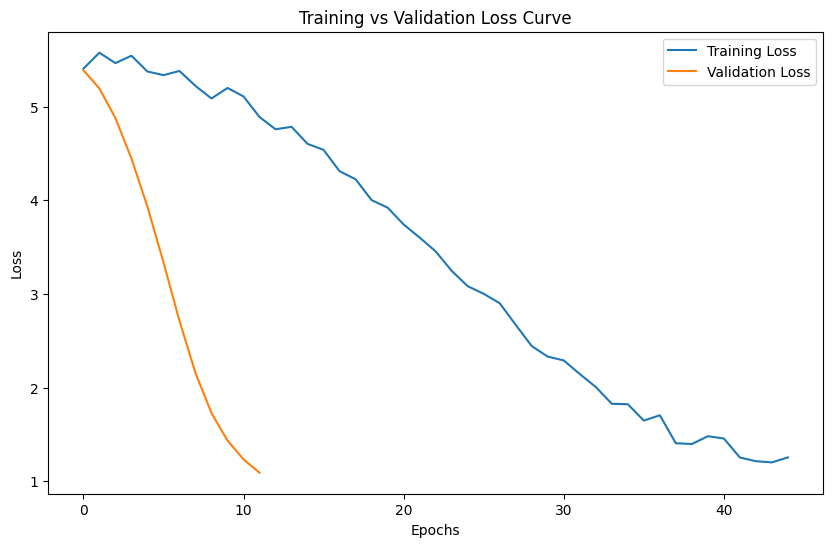

In [ ]:
train_loss = trainer.state.log_history
train_losses = [log['loss'] for log in train_loss if 'loss' in log]
eval_losses = [log['eval_loss'] for log in train_loss if 'eval_loss' in log]


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.show()